### Reemplazar un heap binario por un heap d-ario

En muchas aplicaciones, especialmente aquellas que hacen uso intensivo de colas de prioridad, reemplazar un heap binario por un heap d-ario puede ofrecer mejoras significativas en el rendimiento. Al aumentar el número de hijos por nodo (d), se reducen la altura del árbol y, en consecuencia, la cantidad de comparaciones e intercambios necesarios en ciertas operaciones.

Esta mejora es particularmente útil en algoritmos donde la cola de prioridad es un componente crítico, ya que permite procesar grandes volúmenes de datos de forma más eficiente. Sin embargo, es importante ajustar el factor de ramificación de acuerdo con la naturaleza del problema y el tamaño de los datos.


### Aplicaciones en grafos: Dijkstra y Prim

Las colas de prioridad son fundamentales en el diseño de algoritmos sobre grafos, siendo los más conocidos el algoritmo de Dijkstra para encontrar caminos mínimos y el algoritmo de Prim para calcular el árbol de expansión mínima (MST).

**Dijkstra:**  

Este algoritmo utiliza una cola de prioridad para determinar de manera eficiente la distancia mínima desde un vértice fuente a todos los demás vértices. La eficiencia del algoritmo depende en gran medida de la implementación de la cola de prioridad; reemplazar un heap binario por un heap d-ario puede reducir el número de comparaciones e intercambios, acelerando el proceso.

**Prim:**  

De manera similar, el algoritmo de Prim para encontrar el MST se beneficia de una cola de prioridad para seleccionar la siguiente arista de menor peso que expanda el árbol. Una implementación con un heap d-ario puede mejorar el rendimiento en grafos densos o con muchos vértices.

En ambos casos, la elección de la estructura de datos adecuada para la cola de prioridad es clave para obtener una mejora práctica en la ejecución de estos algoritmos.


### Implementaciones

Distancias desde A : {'A': 0, 'B': 4, 'C': 2, 'D': 9, 'E': 5, 'F': 20}
Predecesores: {'A': None, 'B': 'A', 'C': 'A', 'D': 'E', 'E': 'C', 'F': 'D'}


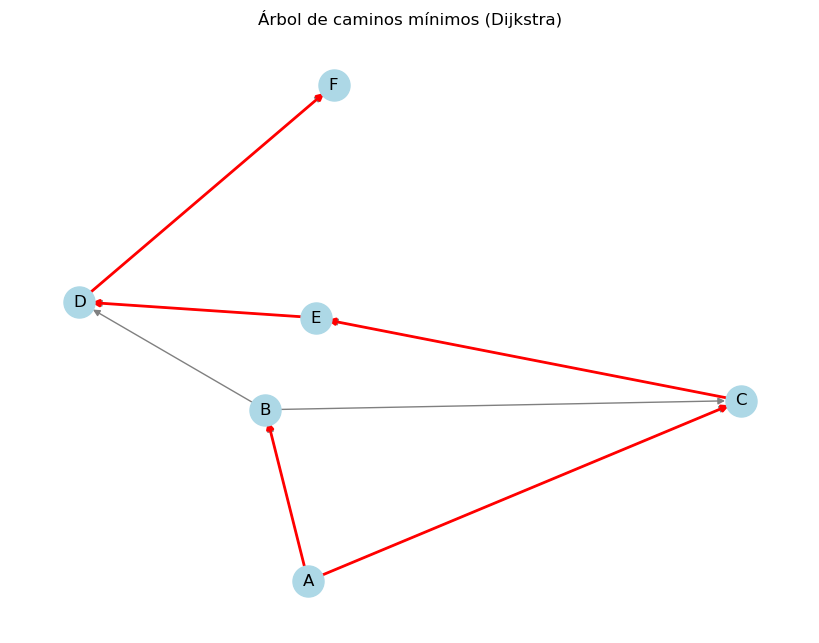

Aristas del MST (Prim): [('A', 'C'), ('C', 'B'), ('B', 'D'), ('D', 'E'), ('E', 'F')]


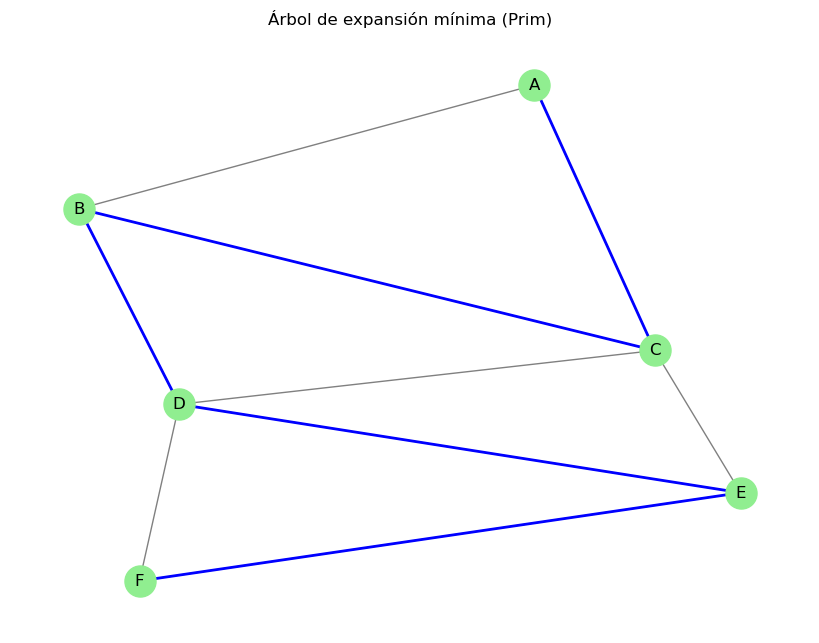

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import Any, List, Optional, Tuple

# Clase DWayHeap modificada para admitir min-heap
class DWayHeap(object):
    def __init__(self, elements: List[Any] = [], priorities: List[float] = [],
                 branching_factor: int = 2, min_heap: bool = False) -> None:
        """
        Args:
            elements: Elementos iniciales.
            priorities: Prioridades asociadas (debe tener la misma longitud que elements).
            branching_factor: Número máximo de hijos por nodo (>= 2).
            min_heap: Si es True, se comporta como un min-heap; en caso contrario, como un max-heap.
        """
        if len(elements) != len(priorities):
            raise ValueError(f'La longitud de elementos ({len(elements)}) debe coincidir con la de prioridades ({len(priorities)}).')
        if branching_factor < 2:
            raise ValueError(f'El factor de ramificación ({branching_factor}) debe ser mayor que 1.')
        self._pairs: List[Tuple[float, Any]] = []
        self.D = branching_factor
        self.min_heap = min_heap  # True para min-heap (usado en Dijkstra y Prim)
        if len(elements) > 0:
            self._heapify(elements, priorities)

    def __sizeof__(self) -> int:
        return len(self)

    def __len__(self) -> int:
        return len(self._pairs)

    def _bubble_up(self, index: int) -> None:
        """Eleva un elemento para restablecer la propiedad del heap."""
        assert (0 <= index < len(self._pairs))
        input_pair = self._pairs[index]
        input_priority = input_pair[0]
        while index > 0:
            parent_index = self._parent_index(index)
            parent = self._pairs[parent_index]
            # Si es min_heap, elevamos cuando la prioridad es menor; sino, cuando es mayor.
            if (self.min_heap and input_priority < parent[0]) or (not self.min_heap and input_priority > parent[0]):
                self._pairs[index] = parent
                index = parent_index
            else:
                break
        self._pairs[index] = input_pair

    def _push_down(self, index: int) -> None:
        """Empuja un elemento hacia abajo para restablecer la propiedad del heap."""
        assert (0 <= index < len(self._pairs))
        input_pair = self._pairs[index]
        input_priority = input_pair[0]
        current_index = index
        first_leaf = self.first_leaf_index()
        while current_index < first_leaf:
            child_index = self._extreme_priority_child_index(current_index)
            assert (child_index is not None)
            # Para min_heap: si el hijo tiene menor prioridad, se intercambia.
            if (self.min_heap and self._pairs[child_index][0] < input_priority) or \
               (not self.min_heap and self._pairs[child_index][0] > input_priority):
                self._pairs[current_index] = self._pairs[child_index]
                current_index = child_index
            else:
                break
        self._pairs[current_index] = input_pair

    def _first_child_index(self, index: int) -> int:
        return index * self.D + 1

    def _parent_index(self, index: int) -> int:
        return (index - 1) // self.D

    def _extreme_priority_child_index(self, index: int) -> Optional[int]:
        """Devuelve el índice del hijo con la prioridad extrema (mínima para min_heap, máxima para max-heap)."""
        first_index = self._first_child_index(index)
        size = len(self)
        last_index = min(first_index + self.D, size)
        if first_index >= size:
            return None
        index_result = first_index
        if self.min_heap:
            extreme_priority = float('inf')
            for i in range(first_index, last_index):
                if self._pairs[i][0] < extreme_priority:
                    extreme_priority = self._pairs[i][0]
                    index_result = i
        else:
            extreme_priority = -float('inf')
            for i in range(first_index, last_index):
                if self._pairs[i][0] > extreme_priority:
                    extreme_priority = self._pairs[i][0]
                    index_result = i
        return index_result

    def first_leaf_index(self) -> int:
        return (len(self) - 2) // self.D + 1

    def _heapify(self, elements: List[Any], priorities: List[float]) -> None:
        assert (len(elements) == len(priorities))
        self._pairs = list(zip(priorities, elements))
        last_inner_node_index = self.first_leaf_index() - 1
        for index in range(last_inner_node_index, -1, -1):
            self._push_down(index)

    def is_empty(self) -> bool:
        return len(self) == 0

    def top(self) -> Any:
        """Elimina y devuelve el elemento en la cima del heap."""
        if self.is_empty():
            raise RuntimeError('Se llamó al método top en un heap vacío.')
        if len(self) == 1:
            element = self._pairs.pop()[1]
        else:
            element = self._pairs[0][1]
            self._pairs[0] = self._pairs.pop()
            self._push_down(0)
        return element

    def peek(self) -> Any:
        """Devuelve el elemento en la cima sin eliminarlo."""
        if self.is_empty():
            raise RuntimeError('Se llamó al método peek en un heap vacío.')
        return self._pairs[0][1]

    def insert(self, element: Any, priority: float) -> None:
        """Inserta un nuevo elemento con su prioridad."""
        self._pairs.append((priority, element))
        self._bubble_up(len(self._pairs) - 1)


# Algoritmo de Dijkstra usando DWayHeap (min-heap)

def dijkstra(graph: nx.DiGraph, source: Any):
    """
    Calcula las distancias mínimas desde 'source' y devuelve un diccionario de distancias
    y otro de predecesores para reconstruir el árbol de caminos mínimos.
    """
    dist = {node: float('inf') for node in graph.nodes()}
    pred = {node: None for node in graph.nodes()}
    dist[source] = 0
    heap = DWayHeap(min_heap=True)
    heap.insert(source, 0)
    
    while not heap.is_empty():
        u = heap.top()
        for v in graph.neighbors(u):
            weight = graph[u][v].get('weight', 1)
            if dist[v] > dist[u] + weight:
                dist[v] = dist[u] + weight
                pred[v] = u
                heap.insert(v, dist[v])
    return dist, pred


# Algoritmo de Prim usando DWayHeap (min-heap)
def prim(graph: nx.Graph, source: Any):
    """
    Calcula el árbol de expansión mínima (MST) usando Prim.
    Devuelve una lista de aristas que conforman el MST.
    """
    visited = {source}
    mst_edges = []
    heap = DWayHeap(min_heap=True)
    for v in graph.neighbors(source):
        weight = graph[source][v].get('weight', 1)
        heap.insert((source, v), weight)
        
    while not heap.is_empty() and len(visited) < len(graph.nodes()):
        edge = heap.top()
        u, v = edge
        if u in visited and v in visited:
            continue  # Ignoramos si ambos vértices ya fueron visitados
        new_vertex = v if u in visited else u
        if new_vertex not in visited:
            visited.add(new_vertex)
            mst_edges.append(edge)
            for w in graph.neighbors(new_vertex):
                if w not in visited:
                    weight = graph[new_vertex][w].get('weight', 1)
                    heap.insert((new_vertex, w), weight)
    return mst_edges

# Ejemplo y visualización: Dijkstra
# Crear un grafo dirigido de ejemplo
G_dijkstra = nx.DiGraph()
edges_dijkstra = [
    ('A', 'B', 4),
    ('A', 'C', 2),
    ('B', 'C', 5),
    ('B', 'D', 10),
    ('C', 'E', 3),
    ('E', 'D', 4),
    ('D', 'F', 11)
]
for u, v, w in edges_dijkstra:
    G_dijkstra.add_edge(u, v, weight=w)

source_node = 'A'
distances, predecessors = dijkstra(G_dijkstra, source_node)
print("Distancias desde", source_node, ":", distances)
print("Predecesores:", predecessors)

# Construir el árbol de caminos mínimos para visualizar
dijkstra_tree = nx.DiGraph()
for node, pred in predecessors.items():
    if pred is not None:
        dijkstra_tree.add_edge(pred, node)

pos = nx.spring_layout(G_dijkstra)
plt.figure(figsize=(8,6))
nx.draw(G_dijkstra, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
nx.draw_networkx_edges(dijkstra_tree, pos, edge_color='red', width=2)
plt.title("Árbol de caminos mínimos (Dijkstra)")
plt.show()

# Ejemplo y visualización: Prim
# Crear un grafo no dirigido de ejemplo
G_prim = nx.Graph()
edges_prim = [
    ('A', 'B', 4),
    ('A', 'C', 2),
    ('B', 'C', 1),
    ('B', 'D', 5),
    ('C', 'D', 8),
    ('C', 'E', 10),
    ('D', 'E', 2),
    ('D', 'F', 6),
    ('E', 'F', 3)
]
for u, v, w in edges_prim:
    G_prim.add_edge(u, v, weight=w)

mst_edges = prim(G_prim, 'A')
print("Aristas del MST (Prim):", mst_edges)

mst_tree = nx.Graph()
mst_tree.add_edges_from(mst_edges)

pos = nx.spring_layout(G_prim)
plt.figure(figsize=(8,6))
nx.draw(G_prim, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500)
nx.draw_networkx_edges(mst_tree, pos, edge_color='blue', width=2)
plt.title("Árbol de expansión mínima (Prim)")
plt.show()


#### Pruebas

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import Any, List, Optional, Tuple
import unittest
import random

# Clase DWayHeap modificada para admitir min-heap o max-heap
class DWayHeap(object):
    def __init__(self, elements: List[Any] = [], priorities: List[float] = [],
                 branching_factor: int = 2, min_heap: bool = False) -> None:
        """
        Args:
            elements: Elementos iniciales.
            priorities: Prioridades asociadas (debe tener la misma longitud que elements).
            branching_factor: Número máximo de hijos por nodo (>= 2).
            min_heap: Si es True, se comporta como un min-heap; en caso contrario, como un max-heap.
        """
        if len(elements) != len(priorities):
            raise ValueError(f'La longitud de elementos ({len(elements)}) debe coincidir con la de prioridades ({len(priorities)}).')
        if branching_factor < 2:
            raise ValueError(f'El factor de ramificación ({branching_factor}) debe ser mayor que 1.')
        self._pairs: List[Tuple[float, Any]] = []
        self.D = branching_factor
        self.min_heap = min_heap  # True para min-heap (usado en Dijkstra y Prim)
        if len(elements) > 0:
            self._heapify(elements, priorities)

    def __sizeof__(self) -> int:
        return len(self)

    def __len__(self) -> int:
        return len(self._pairs)

    def _bubble_up(self, index: int) -> None:
        """Eleva un elemento para restablecer la propiedad del heap."""
        assert (0 <= index < len(self._pairs))
        input_pair = self._pairs[index]
        input_priority = input_pair[0]
        while index > 0:
            parent_index = self._parent_index(index)
            parent = self._pairs[parent_index]
            # Si es min_heap, elevamos cuando la prioridad es menor; sino, cuando es mayor.
            if (self.min_heap and input_priority < parent[0]) or (not self.min_heap and input_priority > parent[0]):
                self._pairs[index] = parent
                index = parent_index
            else:
                break
        self._pairs[index] = input_pair

    def _push_down(self, index: int) -> None:
        """Empuja un elemento hacia abajo para restablecer la propiedad del heap."""
        assert (0 <= index < len(self._pairs))
        input_pair = self._pairs[index]
        input_priority = input_pair[0]
        current_index = index
        first_leaf = self.first_leaf_index()
        while current_index < first_leaf:
            child_index = self._extreme_priority_child_index(current_index)
            assert (child_index is not None)
            if (self.min_heap and self._pairs[child_index][0] < input_priority) or \
               (not self.min_heap and self._pairs[child_index][0] > input_priority):
                self._pairs[current_index] = self._pairs[child_index]
                current_index = child_index
            else:
                break
        self._pairs[current_index] = input_pair

    def _first_child_index(self, index: int) -> int:
        return index * self.D + 1

    def _parent_index(self, index: int) -> int:
        return (index - 1) // self.D

    def _extreme_priority_child_index(self, index: int) -> Optional[int]:
        """Devuelve el índice del hijo con la prioridad extrema (mínima para min_heap, máxima para max-heap)."""
        first_index = self._first_child_index(index)
        size = len(self)
        last_index = min(first_index + self.D, size)
        if first_index >= size:
            return None
        index_result = first_index
        if self.min_heap:
            extreme_priority = float('inf')
            for i in range(first_index, last_index):
                if self._pairs[i][0] < extreme_priority:
                    extreme_priority = self._pairs[i][0]
                    index_result = i
        else:
            extreme_priority = -float('inf')
            for i in range(first_index, last_index):
                if self._pairs[i][0] > extreme_priority:
                    extreme_priority = self._pairs[i][0]
                    index_result = i
        return index_result

    def first_leaf_index(self) -> int:
        return (len(self) - 2) // self.D + 1

    def _heapify(self, elements: List[Any], priorities: List[float]) -> None:
        assert (len(elements) == len(priorities))
        self._pairs = list(zip(priorities, elements))
        last_inner_node_index = self.first_leaf_index() - 1
        for index in range(last_inner_node_index, -1, -1):
            self._push_down(index)

    def is_empty(self) -> bool:
        return len(self) == 0

    def top(self) -> Any:
        """Elimina y devuelve el elemento en la cima del heap."""
        if self.is_empty():
            raise RuntimeError('Se llamó al método top en un heap vacío.')
        if len(self) == 1:
            element = self._pairs.pop()[1]
        else:
            element = self._pairs[0][1]
            self._pairs[0] = self._pairs.pop()
            self._push_down(0)
        return element

    def peek(self) -> Any:
        """Devuelve el elemento en la cima sin eliminarlo."""
        if self.is_empty():
            raise RuntimeError('Se llamó al método peek en un heap vacío.')
        return self._pairs[0][1]

    def insert(self, element: Any, priority: float) -> None:
        """Inserta un nuevo elemento con su prioridad."""
        self._pairs.append((priority, element))
        self._bubble_up(len(self._pairs) - 1)

# Algoritmo de Dijkstra usando DWayHeap (min-heap)
def dijkstra(graph: nx.DiGraph, source: Any):
    """
    Calcula las distancias mínimas desde 'source' y devuelve un diccionario de distancias
    y otro de predecesores para reconstruir el árbol de caminos mínimos.
    """
    dist = {node: float('inf') for node in graph.nodes()}
    pred = {node: None for node in graph.nodes()}
    dist[source] = 0
    heap = DWayHeap(min_heap=True)
    heap.insert(source, 0)
    
    while not heap.is_empty():
        u = heap.top()
        for v in graph.neighbors(u):
            weight = graph[u][v].get('weight', 1)
            if dist[v] > dist[u] + weight:
                dist[v] = dist[u] + weight
                pred[v] = u
                heap.insert(v, dist[v])
    return dist, pred

# Algoritmo de Prim usando DWayHeap (min-heap)
def prim(graph: nx.Graph, source: Any):
    """
    Calcula el árbol de expansión mínima (MST) usando Prim.
    Devuelve una lista de aristas que conforman el MST.
    """
    visited = {source}
    mst_edges = []
    heap = DWayHeap(min_heap=True)
    for v in graph.neighbors(source):
        weight = graph[source][v].get('weight', 1)
        heap.insert((source, v), weight)
        
    while not heap.is_empty() and len(visited) < len(graph.nodes()):
        edge = heap.top()
        u, v = edge
        if u in visited and v in visited:
            continue  # Ignoramos si ambos vértices ya fueron visitados
        new_vertex = v if u in visited else u
        if new_vertex not in visited:
            visited.add(new_vertex)
            mst_edges.append(edge)
            for w in graph.neighbors(new_vertex):
                if w not in visited:
                    weight = graph[new_vertex][w].get('weight', 1)
                    heap.insert((new_vertex, w), weight)
    return mst_edges

# =======================
# Pruebas Unitarias
# =======================
class HeapTest(unittest.TestCase):

    def validate_heap(self, heap: DWayHeap) -> bool:
        """
        Función auxiliar que valida la propiedad del heap.
        Para cada nodo, verifica que su prioridad sea mayor o igual (max-heap) o menor o igual (min-heap)
        que la de sus hijos.
        """
        for i in range(len(heap._pairs)):
            first_child = heap._first_child_index(i)
            last = min(first_child + heap.D, len(heap._pairs))
            for j in range(first_child, last):
                if heap.min_heap:
                    if heap._pairs[i][0] > heap._pairs[j][0]:
                        return False
                else:
                    if heap._pairs[i][0] < heap._pairs[j][0]:
                        return False
        return True

    def test_init(self):
        # Prueba de inicialización: se crea un heap vacío con factor de ramificación 2.
        heap = DWayHeap(branching_factor=2)
        self.assertEqual(0, len(heap))
        # Prueba con valores inválidos para el factor de ramificación.
        for b in [1, 0, -1]:
            with self.assertRaises(ValueError) as context:
                DWayHeap(branching_factor=b)
            self.assertTrue(f'El factor de ramificación ({b}) debe ser mayor que 1.' in str(context.exception))
        # Prueba de inconsistencia entre la longitud de elementos y la de prioridades.
        with self.assertRaises(ValueError) as context:
            DWayHeap(priorities=[1.0])
        error_str = 'La longitud de elementos (0) debe coincidir con la de prioridades (1).'
        self.assertTrue(error_str in str(context.exception))
        # Inicialización con elementos y prioridades válidos.
        heap = DWayHeap(elements=['A', 'B', 'C', 'D'], priorities=[0.1, -0.1, 1.0, -2.0], branching_factor=2)
        self.assertEqual(4, len(heap))
        self.assertTrue(self.validate_heap(heap))

    def test_heapify(self):
        # Prueba de la función heapify para distintos factores de ramificación.
        for b in [2, 3, 4, 5, 6]:
            size = 4 + random.randint(0, 20)
            elements = [chr(i) for i in range(ord('A'), ord('A') + size)]
            priorities = [random.random() for _ in range(size)]
            heap = DWayHeap(elements=elements, priorities=priorities, branching_factor=b)
            self.assertEqual(size, len(heap))
            self.assertTrue(self.validate_heap(heap))

    def test_clear(self):
        # Prueba del comportamiento en heaps vacíos y tras insertar elementos.
        for b in [2, 3, 4, 5, 6]:
            heap = DWayHeap(branching_factor=b)
            with self.assertRaises(RuntimeError) as context:
                heap.peek()
            self.assertTrue('Se llamó al método peek en un heap vacío.' in str(context.exception))
            heap.insert('First', -1e14)
            self.assertEqual('First', heap.peek())
            heap.insert("b", 0)
            heap.insert("c", 0.99)
            heap.insert("second", 1)
            heap.insert("a", -11)
            self.assertEqual('second', heap.peek())

    def test_insert_top(self):
        # Prueba de la inserción y extracción (top) de elementos en el heap.
        for b in [2, 3, 4, 5, 6]:
            heap = DWayHeap(branching_factor=b)
            with self.assertRaises(RuntimeError) as context:
                heap.peek()
            self.assertTrue('Se llamó al método peek en un heap vacío.' in str(context.exception))
            heap.insert('First', -1e14)
            self.assertEqual('First', heap.top())
            self.assertTrue(heap.is_empty())
            heap.insert("b", 0)
            heap.insert("c", 0.99)
            heap.insert("second", 1)
            heap.insert("a", -11)
            self.assertEqual('second', heap.top())
            self.assertEqual(3, len(heap))
            for i in range(10):
                heap.insert(str(i), random.random())
            while not heap.is_empty():
                self.assertTrue(self.validate_heap(heap))
                heap.top()

    def test_dijkstra_algorithm(self):
        # Crear un grafo dirigido de prueba.
        G = nx.DiGraph()
        edges = [
            ('A', 'B', 4),
            ('A', 'C', 2),
            ('B', 'C', 5),
            ('B', 'D', 10),
            ('C', 'E', 3),
            ('E', 'D', 4),
            ('D', 'F', 11)
        ]
        for u, v, w in edges:
            G.add_edge(u, v, weight=w)
        distances, preds = dijkstra(G, 'A')
        expected_distances = {'A': 0, 'B': 4, 'C': 2, 'E': 5, 'D': 9, 'F': 20}
        self.assertEqual(distances, expected_distances)

    def test_prim_algorithm(self):
        # Crear un grafo no dirigido de prueba.
        G = nx.Graph()
        edges = [
            ('A', 'B', 4),
            ('A', 'C', 2),
            ('B', 'C', 1),
            ('B', 'D', 5),
            ('C', 'D', 8),
            ('C', 'E', 10),
            ('D', 'E', 2),
            ('D', 'F', 6),
            ('E', 'F', 3)
        ]
        for u, v, w in edges:
            G.add_edge(u, v, weight=w)
        mst_edges = prim(G, 'A')
        # Verificar que el MST contenga (nodos - 1) aristas.
        self.assertEqual(len(mst_edges), len(G.nodes()) - 1)
        # Verificar que el MST conecta todos los nodos.
        connected_nodes = set()
        for u, v in mst_edges:
            connected_nodes.add(u)
            connected_nodes.add(v)
        self.assertEqual(connected_nodes, set(G.nodes()))

# Ejecutar las pruebas unitarias
suite = unittest.TestLoader().loadTestsFromTestCase(HeapTest)
unittest.TextTestRunner(verbosity=2).run(suite)

test_clear (__main__.HeapTest.test_clear) ... ok
test_dijkstra_algorithm (__main__.HeapTest.test_dijkstra_algorithm) ... ok
test_heapify (__main__.HeapTest.test_heapify) ... ok
test_init (__main__.HeapTest.test_init) ... ok
test_insert_top (__main__.HeapTest.test_insert_top) ... ok
test_prim_algorithm (__main__.HeapTest.test_prim_algorithm) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.025s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

### Ejercicios

1 . Modifica la clase `DWayHeap` para incorporar un método `update(element, new_priority)` que, dado un elemento existente, actualice su prioridad a un valor menor (en un min-heap) o mayor (en un max-heap) y reestablezca la propiedad del heap utilizando los métodos `_bubble_up` o `_push_down` según corresponda.

**Pistas:**  
- Recorrer la lista interna `_pairs` para ubicar el elemento.  
- Comparar la nueva prioridad con la actual y decidir si se debe usar `_bubble_up` o `_push_down`.  
- Asegurarse de que, si el elemento no existe, se maneje de forma adecuada (por ejemplo, lanzar una excepción o insertar el elemento).

2 . Modifica el algoritmo de Dijkstra (y, de manera similar, el de Prim) para evitar la inserción de entradas duplicadas para un mismo vértice. En lugar de insertar duplicados, se debe actualizar la prioridad de la entrada existente (usando el método `update` del ejercicio 1).

**Pistas:**  
- Utiliza una estructura auxiliar (por ejemplo, un diccionario) que lleve el seguimiento de la posición de cada elemento en el heap.  
- Al momento de insertar o actualizar, verifica si el elemento ya se encuentra en el heap.  
- Evalúa cómo afecta esta modificación la complejidad del algoritmo.

3 . Reescribe la función `dijkstra` para que, en lugar de insertar múltiples copias del mismo nodo con diferentes prioridades, utilice el método `update` (o decrease-key) para disminuir la prioridad de un nodo ya presente en el heap.

**Pistas:**  
- Modifica la lógica interna: cuando encuentres un camino más corto hacia un nodo, en lugar de insertar ese nodo de nuevo, llama a `update` para ajustar su prioridad.  
- Comprueba que, al final, la solución obtenida (diccionario de distancias y predecesores) sea correcta y que la cantidad de operaciones sobre el heap se reduzca.

4 . Implementa una función que, a partir de una lista arbitraria de elementos y prioridades, construya un heap utilizando únicamente los métodos `_bubble_up` y `_push_down`, sin utilizar directamente el método `_heapify`.

**Pistas:**  
- Inserta los elementos uno por uno en un heap inicialmente vacío (usando `insert`) y compara el resultado con la construcción mediante `_heapify`.  
- Analiza la complejidad de ambas estrategias y discute cuál es más eficiente en distintos escenarios.

5 . Realiza un experimento comparativo para medir el rendimiento del algoritmo de Dijkstra en dos versiones:
1. La versión actual que permite duplicados en el heap.
2. La versión optimizada que usa el método `update` para disminuir la prioridad (decrease-key).

**Pistas:**  
- Genera grafos grandes (por ejemplo, con miles de vértices y aristas) de manera aleatoria.  
- Mide el tiempo de ejecución de ambos algoritmos y grafica los resultados.  
- Discute los resultados obtenidos y qué versión es más eficiente en función del tamaño del grafo.

6 . Implementa un método adicional en `DWayHeap` (por ejemplo, `to_sorted_list()`) que retorne una lista de los elementos ordenados según su prioridad sin eliminar los elementos del heap.

**Pistas:**  
- Puedes realizar una copia del heap y aplicar sucesivas extracciones usando `top` para formar la lista ordenada.  
- Asegúrate de que la estructura original no se modifique al final del proceso.  
- Compara este método con la función `heapify` en cuanto a eficiencia y comportamiento.


7 . Modifica el parámetro `branching_factor` de la clase `DWayHeap` para diferentes valores (por ejemplo, 2, 4, 8, 16) y mide el rendimiento de los algoritmos de Dijkstra y Prim en grafos de distinto tamaño.  

**Pistas:**  

- Crea grafos con varios números de nodos y aristas.
- Utiliza la función `time` o `timeit` para medir el tiempo de ejecución.
- Analiza cómo cambia la eficiencia en función del factor de ramificación.

8 . Extiende la clase `DWayHeap` para incluir una operación `decrease_key` (actualización de prioridad) y modifica el algoritmo de Dijkstra para aprovecharla en lugar de insertar duplicados.  

**Pistas:**  
- Implementa un mecanismo para buscar y actualizar la prioridad de un elemento en el heap.
- Asegúrate de reestablecer la propiedad del heap luego de la actualización.
- Compara la eficiencia con la versión actual de Dijkstra.

9 . Crea un grafo dirigido con pesos que varíen en un rango amplio y visualiza cómo varían las distancias mínimas calculadas a partir de un vértice fuente.  

**Pistas:**  

- Genera grafos aleatorios utilizando NetworkX.  
- Aplica el algoritmo de Dijkstra y visualiza el árbol de caminos mínimos resaltando las aristas del árbol en el grafo original.

10 .  Adapta el algoritmo de Prim para que pueda calcular un bosque de expansión mínima (Minimum Spanning Forest) en un grafo no dirigido que puede estar desconexo.  

**Pistas:**  

- Ejecuta Prim en cada componente conexo del grafo.
- Combina los resultados para visualizar el bosque de expansión mínima.
     
11 . Implementa una visualización comparativa en la que se muestre el grafo original junto a la solución de Dijkstra (camino mínimo) y el MST obtenido con Prim, resaltando claramente las diferencias y similitudes en la estructura.

**Pistas:**  

- Utiliza subplots en Matplotlib para mostrar ambos resultados.
- Agrega leyendas y colores distintivos para identificar cada solución.
     
12 . Desarrolla una batería de pruebas unitarias para la clase `DWayHeap` que verifique las operaciones básicas (insert, top, peek) y que se asegure de que se mantenga la invariante del heap después de cada operación.  

**Pistas:**  

- Usa el framework `unittest` o `pytest`.  
- Crea casos de prueba con heaps pequeños y realiza operaciones que modifiquen la estructura, verificando el orden esperado.


In [ ]:
## Tus respuestas